# Template

## Introduction

This Jupyter notebook serves as a comprehensive demonstration of how to set up and simulate magnetic resonance (MR) sequences using the `pypulseq` and `MRzeroCore` libraries. The notebook is structured to guide users through the process of configuring system parameters, defining various MR events, constructing sequences, and ultimately simulating MR data using custom or pre-defined phantoms.

### Key Sections:
1. **System Setup**: This section covers the configuration of essential system parameters, such as gradient strength, slew rate, and RF pulse properties, which are critical for simulating realistic MR sequences.

2. **Event Definitions**: In this section, various MR events, including RF pulses, gradient events, and ADC (Analogue-to-Digital Conversion) events, are defined. These events are the building blocks of MR sequences.

3. **Sequence Construction**: This section demonstrates how to combine the defined events into a coherent MR sequence. It also covers the process of writing sequences to external files for further analysis or simulation.

4. **Sequence Application**: The final section focuses on applying the constructed sequences to MR phantoms. Users will learn how to load or create custom phantoms, simulate MR data, and visualize the results, including k-space trajectories and signal plots.

This notebook can serve as a template for developing more complex MR simulations or for adapting the provided code to specific research needs.

## Table of Contents
- [1. System Setup](#1.-System-Setup)
- [2. Event Definitions](#2.-Event-Definitions)
  - [2.1 RF Events](#RF-Events)
  - [2.2 Gradient Events](#Gradient-Events)
  - [2.3 Analogue-To-Digital Conversion (ADC) event and Delay](#Analogue-To-Digital-Conversion-(ADC)-event-and-Delay)
- [3. Sequence Construction](#3.-Sequence-Construction)
  - [3.1 Sequence Building](#3.1-Sequence-Building)
  - [3.2 Writing Sequence to an External File](#3.2-Writing-Sequence-to-an-External-File)
  - [3.3 Loading a Sequence from an External File](#3.3-Loading-a-Sequence-from-an-External-File)
- [4. Sequence Application](#4.-Sequence-Application)
  - [4.1 Loading in a Custom Phantom](#4.1-Loading-in-a-Custom-Phantom)
  - [4.2 Making a Custom Phantom](#4.2-Making-a-Custom-Phantom)
  - [4.3 Converting the Phantom into Simulation Data](#4.3-Converting-the-Phantom-into-Simulation-Data)
- [5. Simulating the Sequence](#5.-Simulating-the-Sequence)

In [15]:
#Requirements: Uncomment and run if not yet installed

#!pip install torch torchvision torchaudio
#!pip install MrzeroCore
#!pip install pypulseq==1.3.1.post1
#!pip install torchkbnufft==1.3.0 --no-deps
#!pip install scikit-image
#!pip install PyWavelets

# 1. System Setup
```
system = pp.Opts(adc_dead_time: float = 0,
                 gamma: float = 42.576e6,
                 grad_raster_time: float = 10e-6,
                 grad_unit: str = 'Hz/m',
                 max_grad: float = 0,
                 max_slew: float = 0,
                 rf_dead_time: float = 0,
                 rf_raster_time: float = 1e-6,
                 rf_ringdown_time: float = 0,
                 rise_time: float = 0,
                 slew_unit: str = 'Hz/m/s'
                 )
```
<code>adc_dead_time</code> = Dead time before the ADC is turned on <br>
<code>gamma</code> = Gyromagnetic Ratio of H [MHz/T] <br>
<code>grad_raster_time</code> = Spacing between gradient amplitude updates <br>
<code>grad_unit</code> = Gradient strength unit [T/m or Hz/m] <br>
<code>max_grad</code> = Maximal gradient strength in <code>grad_unit</code> <br>
<code>max_slew</code> = Maximal slew rate in <code>slew_unit</code> <br>
<code>rf_dead_time</code> = Dead time before the RF excitation pulse is turned on [s]<br>
<code>rf_raster_time</code> = Spacing between RF amplitude updates [s]<br>
<code>rf_ringdown_time</code> = Time period during which the RF coil continues to oscillate after the RF excitation pulse has been turned off [s]<br>
<code>rise_time</code> = Gradient rise time [s]<br>
<code>slew_unit</code> = Slew rate unit [T/m/s or Hz/m/s]<br>

In [16]:
import pypulseq as pp
import numpy as np
import MRzeroCore as mr0
import numpy as np
import torch
import matplotlib.pyplot as plt

# Example System Setup
system = pp.Opts(max_grad=28,             
                 grad_unit='mT/m',                   
                 max_slew=150,                        
                 slew_unit='T/m/s',     
                 rf_ringdown_time=20e-6,                                     
                 rf_dead_time=100e-6,             
                 adc_dead_time=20e-6,   
                 grad_raster_time=50 * 10e-6 
                )

# 2. Event Definitions
## RF Events

```
rf, _, _ = make_sinc_pulse(flip_angle: float,
                           apodization: float = 0,
                           delay: float = 0,
                           duration: float = 0,
                           freq_offset: float = 0,
                           center_pos: float = 0.5,
                           max_grad: float = 0,
                           max_slew: float = 0,
                           phase_offset: float = 0,
                           return_gz: bool = False,
                           slice_thickness: float = 0,
                           system: Opts = Opts(),
                           time_bw_product: float = 4,
                           use: str = str()
                           )
```
<code>flip_angle</code> = Flip angle [rad] <br>
<code>apodization</code> = Apodization <br>
<code>delay</code> = Predetermined delay before the RF pulse starts [s] **(\*)**<br>
<code>duration</code> = Duration of the RF pulse [s] <br>
<code>freq_offset</code> = Frequency offset [rad] <br>
<code>center_pos</code> = Position of the peak relative to the start of the RF pulse <br>
<code>max_grad</code> = Maximum gradient strength of accompanying slice select trapezoidal event <br>
<code>max_slew</code> = Maximum slew rate of accompanying slice select trapezoidal event <br>
<code>phase_offset</code> = Phase offset [rad] <br>
<code>return_gz</code> = Boolean flag to indicate if slice-selective gradient has to be returned <br>
<code>slice_thickness</code> = Slice thickness of accompanying slice select trapezoidal event [m] **(\*\*)**<br>
<code>system</code> = System limits <br>
<code>time_bw_product</code> = Time-bandwidth product <br>
<code>use</code> = Use of radio-frequency sinc pulse ['excitation', 'refocusing','inversion']<br>

<br><br>
**(\*)** : RF delays can be overruled by system limited delays <br>
**(\*\*)** : Slice thickness determines the area of the slice select even

In [17]:
# Example rf event
rf, gz, gzr = pp.make_sinc_pulse(flip_angle= 90.0 * np.pi / 180,     
                                duration=2e-3,                      
                                slice_thickness=8e-3,              
                                apodization=0.5,                   
                                time_bw_product=4,                  
                                system=system,                      
                                return_gz=True 
                             )

#gz  : Optional accompanying slice select trapezoidal gradient event
#gzr : Optional accompanying slice select rephasing trapezoidal gradient event

## Gradient Events
```
g = make_trapezoid(channel: str,
                   amplitude: float = 0,
                   area: float | None = None,
                   delay: float = 0,
                   duration: float = 0,
                   flat_area: float = 0,
                   flat_time: float = -1,
                   max_grad: float = 0,
                   max_slew: float = 0,
                   rise_time: float = 0,
                   system: Opts = Opts()
                   )
```

<code>channel</code> = Orientation of the trapezoidal gradient event ['x', 'y', 'z']<br>
<code>amplitude</code> = Amplitude of the trapezoidal gradient event <br>
<code>area</code> = Area of the trapezoidal gradient event<br>
<code>delay</code> = Predetermined delay before the gradient is turned on [s] **(\*)**<br>
<code>duration</code> = Duration of the gradient event [s]<br>
<code>flat_area</code> = Flat area of the trapezoidal gradient event <br>
<code>flat_time</code> = Flat time of the trapezoidal gradient event [s] **(\*\*)**<br>
<code>max_grad</code> = Maximum gradient strength <br>
<code>max_slew</code> = Maximum slew rate <br>
<code>rise_time</code> = Gradient rise time [s] <br>
<code>system</code> = System limits <br>

<br><br>
**(\*)** : Gradient delays can be overruled by system limited delays <br>
**(\*\*)** : Default is -1 to account for triangular pulses

In [18]:
# Example gradient event
gx = pp.make_trapezoid(channel='x', 
                       area=80, 
                       duration=2e-3, 
                       system=system
                      )

## Analogue-To-Digital Conversion (ADC) event and Delay
```
adc = make_adc(num_samples: int,
               system: Opts = Opts(),
               dwell: float = 0,
               duration: float = 0,
               delay: float = 0,
               freq_offset: float = 0,
               phase_offset: float = 0
               )
```
<code>num_samples</code> = Number of readout samples<br>
<code>system</code> = System limits<br>
<code>dwell</code> = ADC dead time after sampling [s]<br>
<code>duration</code> = Duration in milliseconds of ADC readout event with `num_samples` number of samples [s]<br>
<code>delay</code> = Predetermined delay before the ADC is turned on [s]<br>
<code>freq_offset</code> = Frequency offset [rad]<br>
<code>phase_offset</code> = Phase offset [rad]<br>

<br>

```
delay =  make_delay(d: float)
```
<code>d</code> = Delay in between blocks [s]<br>

# 3. Sequence Construction
## 3.1 Sequence Building

In [19]:
# Example of a the system setup and event definitions of a SE sequence

# --------------------------- 1. System & Imaging Parameters --------------------------

system = pp.Opts(max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
                 rf_ringdown_time=20e-6, rf_dead_time=100e-6, adc_dead_time=20e-6)

fov, Nread, Nphase, slice_thickness = 1000e-3, 128, 1, 8e-3  
seq = pp.Sequence(system)

# ------------------------------- 2. Event Definitions --------------------------------

rf1, _, _ = pp.make_sinc_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, slice_thickness=slice_thickness, 
                               apodization=0.5, time_bw_product=4, system=system, return_gz=True)

rf2, _, _ = pp.make_sinc_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, slice_thickness=slice_thickness, 
                               apodization=0.5, time_bw_product=4, system=system, return_gz=True)

adc = pp.make_adc(num_samples=Nread, duration=200e-3, system=system)
delay = pp.make_delay(0.1)


# ------------------------------ 3. Sequence Construction -----------------------------

seq = pp.Sequence(system)

seq.add_block(rf1)
seq.add_block(delay,adc)
seq.add_block(rf2)
seq.add_block(delay,adc)
seq.add_block(delay,adc)
seq.add_block(rf2)
seq.add_block(delay,adc)
seq.add_block(delay,adc)

# !!! pypulseq 1.3.1post1 write() crashes 
#     when there is no gradient event !!!
seq.add_block(pp.make_trapezoid('x', duration=1e-3, flat_time =-1, area = 1))  

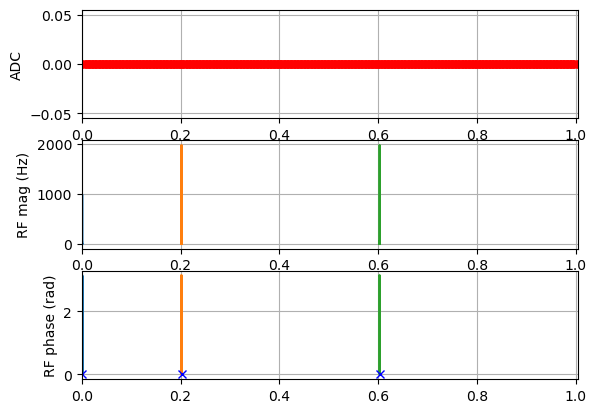

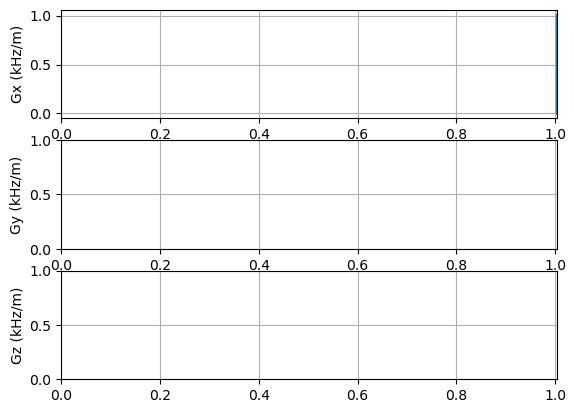

In [20]:
# Plotting the Sequence Events
sp_adc, t_adc = mr0.util.pulseq_plot(seq)

# 3.2 Writing Sequence to an External File
```
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', Name)
seq.write('out/external.seq')
seq.write('./out/' + experiment_id + '.seq')
```

In [21]:
Name = 'Template'
experiment_id = 'TEMP'

seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', Name)
seq.write('./out/' + experiment_id + '.seq')

# 3.3 Loading a Sequence from an External File
```
seq = mr0.Sequence.import_file('path/external.seq')
```

In [22]:
seq0 = mr0.Sequence.import_file('./out/' + experiment_id + '.seq')

# 4. Sequence Application

## 4.1 Loading in a Custom Phantom

```
sz = [64, 64]    # image size
obj_p = mr0.VoxelGridPhantom.load_mat('Custom Data Path')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Additional Data Manipulation
obj_p.B0 *= 1    # altering the B0 inhomogeneity
obj_p.D *= 0     # altering the Diffusion Coefficient
```

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


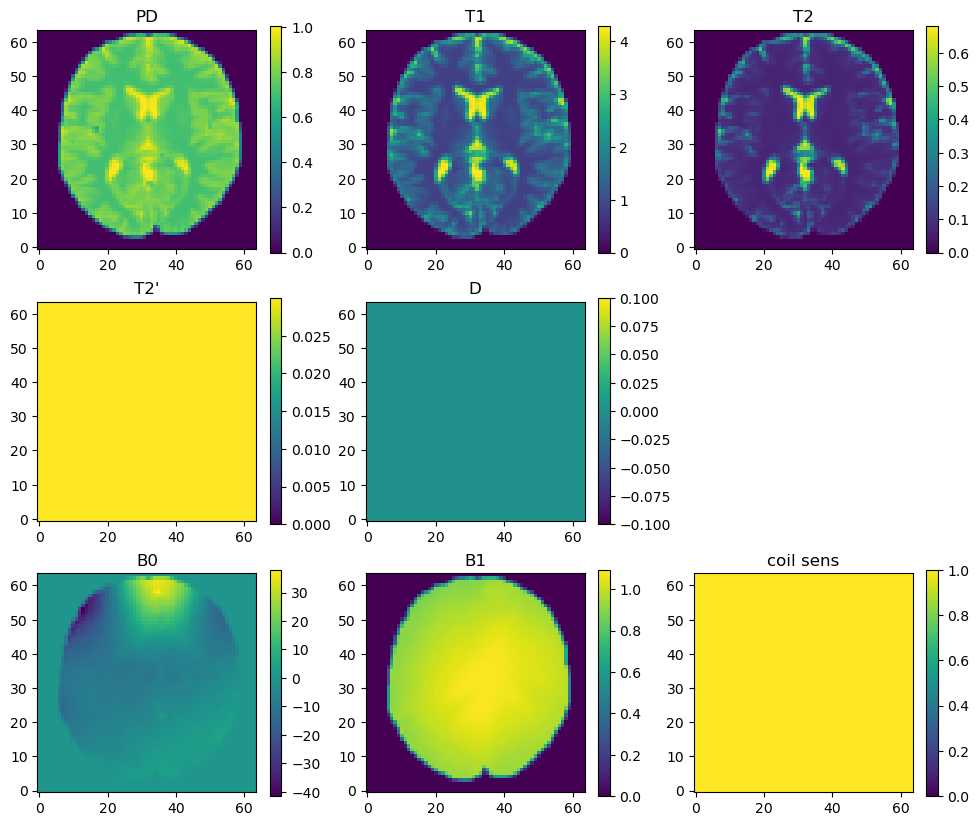

In [23]:
sz = [64,64]

obj_p = mr0.VoxelGridPhantom.load_mat('./data/numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

obj_p.B0 *= 1
obj_p.D *= 0

obj_p.plot()

## 4.2 Making a Custom Phantom
```
obj_p = mr0.CustomVoxelPhantom(pos: list[list[float]] | Tensor,
                               PD: float | list[float] | Tensor = 1.0,
                               T1: float | list[float] | Tensor = 1.5,
                               T2: float | list[float] | Tensor = 0.1,
                               T2dash: float | list[float] | Tensor = 0.05,
                               D: float | list[float] | Tensor = 1,
                               B0: float | list[float] | Tensor = 0,
                               B1: float | list[float] | Tensor = 1,
                               voxel_size: float = 0.1,
                               voxel_shape: str = "sinc"`
```

<code>pos</code> = tensor containing voxel positions [m] **(\*)**<br>
<code>PD</code> = tensor containing proton denisities of all voxels<br>
<code>T1</code> = tensor containing the T1 relaxation of all voxels<br>
<code>T2</code> = tensor containing the T2 relaxation of all voxels<br>
<code>T2dash</code> = tensor containing the T2' relaxation of all voxels<br>
<code>D</code> = tensor containing the diffusion coefficient of all voxels<br>
<code>B0</code> = 1D tensor containing the dB0 off-resonance (∆B0)<br>
<code>B1</code> = tensor containing the relative B1 field strength<br>
<code>voxel_size</code> = 3-element tensor containing the size of a voxel<br>
<code>voxel_shape</code> = Can be one of ['sinc', 'exact_sinc', 'box', 'gauss']<br>

<br><br>
**(\*)** The coordinate system consists of a $(-0.5, 0.5)^3$ space. However, the plotting ranges show $(-1, 1)^3$

CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.2500, 0.2500, 0.2500])


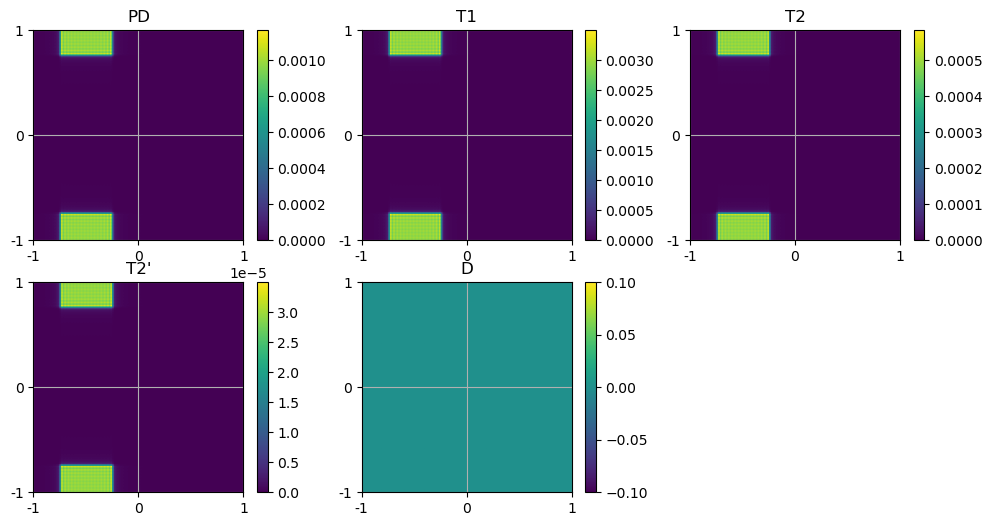

In [24]:
obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.25, -0.5, 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.25,
        voxel_shape="box"
    )

obj_p.plot()

## 4.3 Converting the Phantom into Simulation Data
```
obj_p.size=torch.tensor([fov, fov, slice_thickness]) 
obj_p = obj_p.build()
```

In [25]:
obj_p.size=torch.tensor([fov, fov, slice_thickness]) 
obj_p = obj_p.build()

# 5. Simulating the Sequence
```
graph = mr0.compute_graph(seq: Sequence,
                          data: SimData,
                          max_state_count: int = 200,
                          min_state_mag: float = 1e-4
                          )
```
<code>seq</code> = Sequence **(\*)**<br>
<code>data</code> = Phantom build <br> 
<code>max_state_count</code> = ? <br>
<code>max_state_mag</code> = ? <br>

<br>

```
signal = mr0.execute_graph(graph : Graph, 
                           seq : Sequence, 
                           data : SimData
                           )
```
<code>graph</code> =  Graph<br>
<code>seq</code> = Sequence **(\*)**<br>
<code>data</code> = Phantom build <br>

<br><br>
**(\*)** Only works with externally loaded sequence files. Always first write your sequence to an external file.
<br>

In [26]:
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p)

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000059 s
Compute Graph
Computing Graph: 0.000081125 s
Analyze Graph
Analyzing Graph: 0.000000709 s
Converting Rust -> Python: 0.000008625 s
<<<< Rust <<<<
Calculating repetition 3 / 3 - done


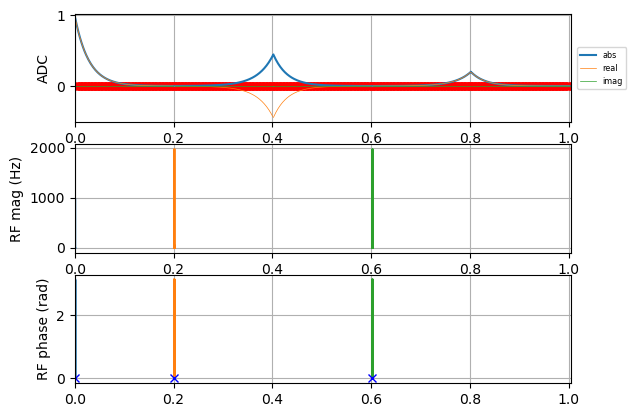

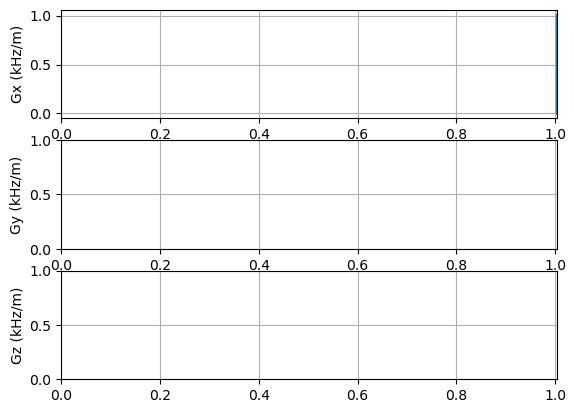

In [27]:
# Plotting the Sequence along with the obtained Signals from the Phantom 
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())

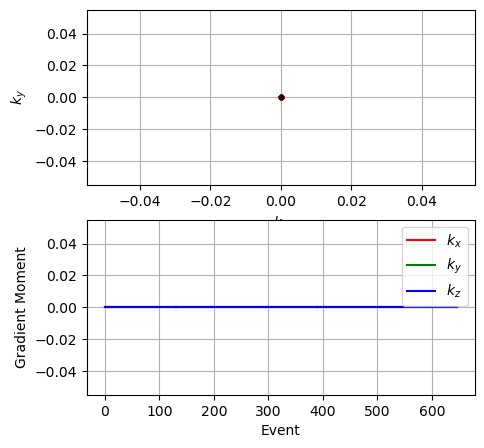

In [28]:
# Plotting the k-space trajectory of the sequence
seq0.plot_kspace_trajectory()